In [46]:
# Clone PatchTST repository and set it as working directory
import os

# Change to the repository directory
os.chdir('/content/PatchTST')
print(f"Current directory: {os.getcwd()}")

Current directory: /content/PatchTST


## 1. Setup and Installation <a id='setup'></a>

First, let's import necessary libraries and set up the environment.

In [47]:
import sys
import os

# Add PatchTST_supervised to path
sys.path.append('/content/PatchTST/PatchTST_supervised')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.8.0+cu126
CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 4060 Laptop GPU


## 2. Understanding Variable-Length PatchTST Architecture <a id='architecture'></a>

### Key Concepts:

**Variable-Length Patching**: Different channels use different patch lengths optimized for their temporal characteristics. This allows each weather variable to be analyzed at its natural time scale.

**Channel-Independence with Per-Channel Scales**: Each channel is still processed independently (no cross-channel attention), but each channel uses a patch length tuned to its dynamics:
- **Fast-changing variables** (wind, precipitation): Short patches (8-12 steps)
- **Medium-changing variables** (humidity, pressure): Medium patches (16-24 steps)  
- **Slow-changing variables** (temperature trends): Long patches (32-48 steps)

### Architecture Components:
1. **RevIN (Reversible Instance Normalization)**: Normalizes input data per channel
2. **Per-Channel Patching Layer**: Different patch lengths for different variable types
3. **Channel-Independent Transformer Encoders**: Separate processing per channel group
4. **Weighted Fusion Head**: Combines multi-scale representations
5. **Prediction Head**: Maps fused features to predictions

In [ ]:
# Change to PatchTST_supervised directory for imports
os.chdir('/content/PatchTST/PatchTST_supervised')
print(f"Changed to: {os.getcwd()}")

# Import PatchTST components
from models.PatchTST import Model as PatchTST
from layers.PatchTST_backbone import PatchTST_backbone, TSTiEncoder, Flatten_Head
from layers.PatchTST_layers import *
from layers.RevIN import RevIN

# Change back to root directory
os.chdir('..')
print(f"Back to: {os.getcwd()}")

# Visualize the Variable-Length architecture
print("\n" + "=" * 60)
print("Variable-Length PatchTST Architecture (Channel-Independent)")
print("=" * 60)
print("\n1. Input Time Series: [Batch, Seq_len, Channels]")
print("   ↓")
print("2. RevIN: Per-channel normalization")
print("   ↓")
print("3. Channel Grouping: Group channels by temporal dynamics")
print("   • Fast channels (wind, precip) → short patches (12 steps)")
print("   • Medium channels (humidity, pressure) → medium patches (24 steps)")
print("   • Slow channels (temperature) → long patches (48 steps)")
print("   ↓")
print("4. Per-Group Patching & Encoding (Channel-Independent)")
print("   • Each group uses its optimal patch length")
print("   • Separate TSTiEncoder per scale")
print("   ↓")
print("5. Weighted Feature Fusion: Combine multi-scale outputs")
print("   ↓")
print("6. Prediction Head: Generate forecasts")
print("   ↓")
print("7. RevIN Denormalization")
print("   ↓")
print("8. Output: [Batch, Pred_len, Channels]")
print("=" * 60)

Changed to: /content/PatchTST/PatchTST_supervised
Back to: /content/PatchTST

PatchTST Architecture Overview

1. Input Time Series: [Batch, Seq_len, Channels]
   ↓
2. RevIN: Normalization
   ↓
3. Patching: Divide into patches [Batch, Channels, Patch_num, Patch_len]
   ↓
4. Transformer Encoder: Process patches
   ↓
5. Flatten & Linear Head: Generate predictions
   ↓
6. RevIN Denormalization
   ↓
7. Output: [Batch, Pred_len, Channels]


## 3. Data Loading and Preparation <a id='data'></a>

Let's explore the data loading process and prepare a sample dataset.

In [ ]:
from data_provider.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom
from data_provider.data_factory import data_provider
from torch.utils.data import DataLoader
import random

def set_seed(seed):
    """Set random seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {seed}")

# Weather dataset channel information (21 variables)
# Based on typical weather station measurements
WEATHER_CHANNELS = {
    # Fast-changing variables (use short patches ~12 steps = 2 hours at 10-min intervals)
    'fast': {
        'indices': [7, 8, 9, 10, 11],  # Wind-related, precipitation
        'names': ['wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)'],
        'patch_len': 12,
        'stride': 6,
        'description': 'Fast-changing: wind, precipitation (2-hour patches)'
    },
    # Medium-changing variables (use medium patches ~24 steps = 4 hours)
    'medium': {
        'indices': [3, 4, 5, 6, 12, 13, 14],  # Humidity, pressure, radiation
        'names': ['rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 
                  'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)'],
        'patch_len': 24,
        'stride': 12,
        'description': 'Medium-changing: humidity, vapor pressure (4-hour patches)'
    },
    # Slow-changing variables (use long patches ~48 steps = 8 hours)
    'slow': {
        'indices': [0, 1, 2, 15, 16, 17, 18, 19, 20],  # Temperature, long-term patterns
        'names': ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 
                  'Tlog (degC)', 'CO2 (ppm)', 'PAR (μmol/m²/s)', 
                  'Tmax (degC)', 'Tmin (degC)'],
        'patch_len': 48,
        'stride': 24,
        'description': 'Slow-changing: temperature, pressure trends (8-hour patches)'
    }
}

# Define configuration class for Variable-Length PatchTST
class VariableLengthConfig:
    def __init__(self):
        self.random_seed = 2021

        # Data parameters
        self.data = 'custom'
        self.root_path = '/content/PatchTST/datasets/weather'
        self.data_path = 'weather.csv'
        self.features = 'M'
        self.target = 'OT'
        self.freq = 't'  # minutely
        self.embed = 'timeF'
        
        # Forecasting task
        self.seq_len = 512    # Input sequence length (~3.5 days)
        self.label_len = 48   # Not used in PatchTST
        self.pred_len = 336   # Prediction length (~2.3 days)
        
        # Model parameters (shared across scales)
        self.model = 'VariableLengthPatchTST'
        self.enc_in = 21      # Total channels
        self.dec_in = 21
        self.c_out = 21
        self.d_model = 128
        self.n_heads = 16      # Reduced for memory efficiency
        self.e_layers = 3
        self.d_layers = 1
        self.d_ff = 256
        self.dropout = 0.2
        self.fc_dropout = 0.2
        self.head_dropout = 0.0
        
        # Variable-length patching configuration
        self.channel_groups = WEATHER_CHANNELS
        self.patch_configs = {
            'fast': {'patch_len': 12, 'stride': 6, 'weight': 0.25},
            'medium': {'patch_len': 24, 'stride': 12, 'weight': 0.50},
            'slow': {'patch_len': 48, 'stride': 24, 'weight': 0.25}
        }
        
        # Legacy PatchTST params (for compatibility)
        self.patch_len = 16
        self.stride = 8
        self.padding_patch = 'end'
        self.revin = 1
        self.affine = 0
        self.subtract_last = 0
        self.decomposition = 0
        self.kernel_size = 25
        self.individual = 1  # Individual head per channel (important for variable-length)
        
        # Training parameters
        self.batch_size = 32
        self.learning_rate = 0.0001
        self.train_epochs = 100
        self.patience = 10
        self.num_workers = 0
        self.lradj = 'type3'
        self.use_amp = False
        self.pct_start = 0.3
        
        # GPU
        self.use_gpu = True if torch.cuda.is_available() else False
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0'

        # Other
        self.checkpoints = '/content/model/checkpoints_variable_length'
        self.output_attention = False
        self.embed_type = 0
        self.activation = 'gelu'
        self.distil = True
        self.factor = 1
        self.moving_avg = 25
        self.do_predict = False
        self.itr = 1
        self.des = 'VariableLength_Exp'
        self.loss = 'mse'
        
args = VariableLengthConfig()
set_seed(args.random_seed)

# Print channel grouping info
print("\n" + "=" * 70)
print("Weather Channel Grouping for Variable-Length Patching")
print("=" * 70)
for group_name, group_info in WEATHER_CHANNELS.items():
    print(f"\n{group_name.upper()} Group:")
    print(f"  Description: {group_info['description']}")
    print(f"  Patch length: {group_info['patch_len']} steps ({group_info['patch_len']*10} minutes)")
    print(f"  Stride: {group_info['stride']} steps ({group_info['stride']*10} minutes)")
    print(f"  Channels ({len(group_info['indices'])}): {group_info['names'][:3]}...")
print("=" * 70)

Random seed set to: 2021


✓ Dataset found at: /content/PatchTST/datasets/weather/weather.csv

Dataset shape: (52696, 22)

First few rows:
                  date  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  2020-01-01 00:10:00   1008.89      0.71    273.18        -1.33    86.1   
1  2020-01-01 00:20:00   1008.76      0.75    273.22        -1.44    85.2   
2  2020-01-01 00:30:00   1008.66      0.73    273.21        -1.48    85.1   
3  2020-01-01 00:40:00   1008.64      0.37    272.86        -1.64    86.3   
4  2020-01-01 00:50:00   1008.61      0.33    272.82        -1.50    87.4   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  ...  wv (m/s)  \
0          6.43          5.54          0.89       3.42  ...      1.02   
1          6.45          5.49          0.95       3.39  ...      0.43   
2          6.44          5.48          0.96       3.39  ...      0.61   
3          6.27          5.41          0.86       3.35  ...      1.11   
4          6.26          5.47          0.79       3.38  ... 

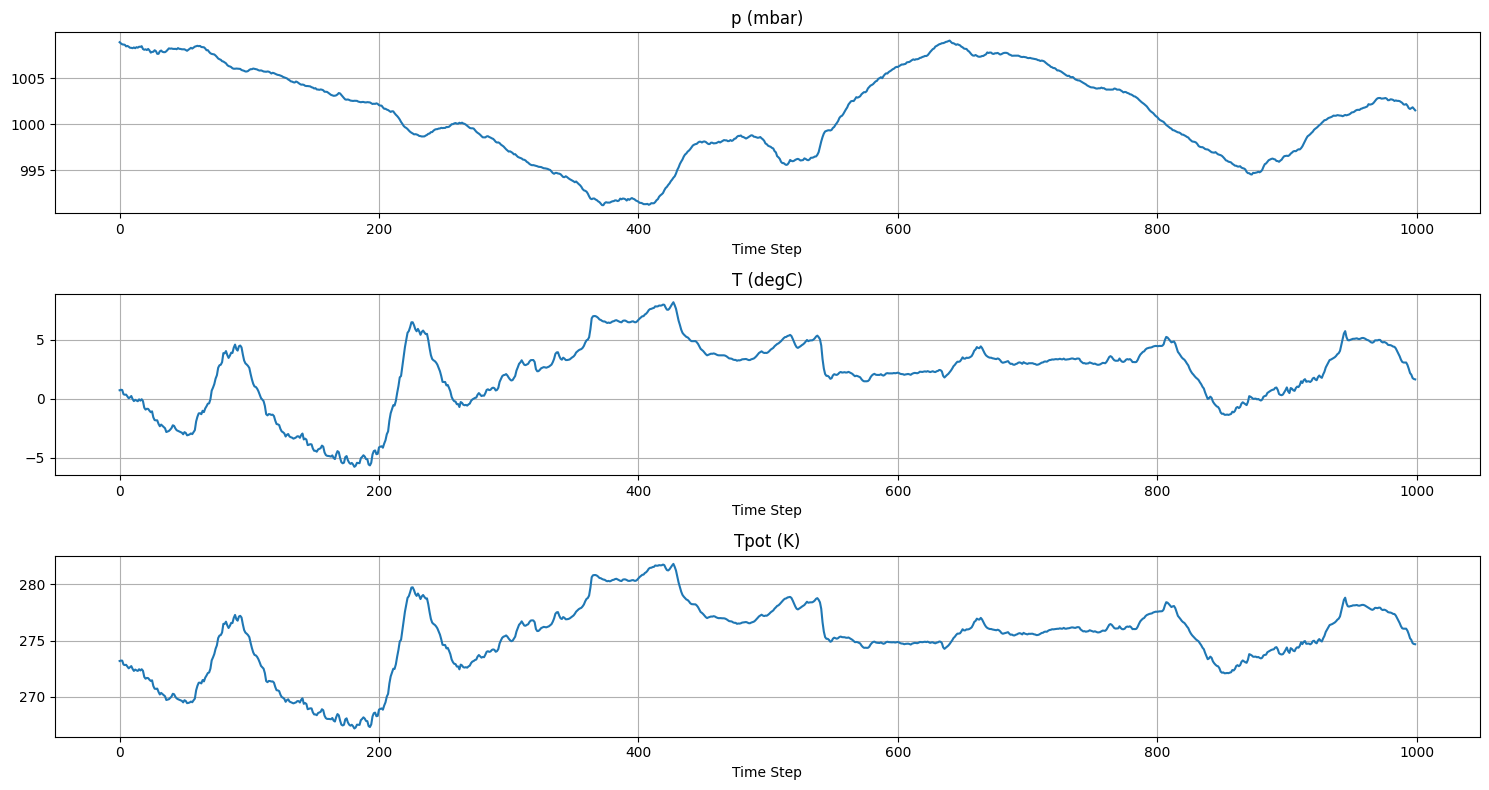

In [50]:
# Check if dataset exists
dataset_path = os.path.join(args.root_path, args.data_path)
if os.path.exists(dataset_path):
    print(f"✓ Dataset found at: {dataset_path}")
    
    # Load and explore the dataset
    df = pd.read_csv(dataset_path)
    print(f"\nDataset shape: {df.shape}")
    print(f"\nFirst few rows:")
    print(df.head())
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nData types:")
    print(df.dtypes)
    
    # Visualize a sample of the data
    fig, axes = plt.subplots(3, 1, figsize=(15, 8))
    for i, col in enumerate(df.columns[1:4]):
        axes[i].plot(df[col][:1000])
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel('Time Step')
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"✗ Dataset not found at: {dataset_path}")
    print(f"\nPlease download the dataset from:")
    print(f"https://drive.google.com/drive/folders/1ZOYpTUa82_jCcxIdTmyr0LXQfvaM9vIy")
    print(f"\nAnd place it in the {args.root_path} folder")

In [51]:
train_data, train_loader = data_provider(args, flag='train')
val_data, val_loader = data_provider(args, flag='val')
test_data, test_loader = data_provider(args, flag='test')

print(f"\nData Loaders Created:")
print(f"  Training samples: {len(train_data)}")
print(f"  Validation samples: {len(val_data)}")
print(f"  Test samples: {len(test_data)}")

# Inspect a batch
for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
    print(f"\nBatch shapes:")
    print(f"  Input (batch_x): {batch_x.shape}")
    print(f"  Target (batch_y): {batch_y.shape}")
    print(f"  Input time features (batch_x_mark): {batch_x_mark.shape}")
    print(f"  Target time features (batch_y_mark): {batch_y_mark.shape}")
    break

train 36040
val 4935
test 10204

Data Loaders Created:
  Training samples: 36040
  Validation samples: 4935
  Test samples: 10204

Batch shapes:
  Input (batch_x): torch.Size([32, 512, 21])
  Target (batch_y): torch.Size([32, 384, 21])
  Input time features (batch_x_mark): torch.Size([32, 512, 5])
  Target time features (batch_y_mark): torch.Size([32, 384, 5])


## 4. Variable-Length PatchTST Model Definition <a id='model'></a>

This custom model uses different patch lengths for different channel groups while maintaining channel-independent processing. Each channel group (fast/medium/slow) has its own encoder optimized for its temporal dynamics.

In [ ]:
# Variable-Length PatchTST Model (Channel-Independent with Per-Channel Patch Lengths)

class PerChannelEncoder(nn.Module):
    """Encoder for a group of channels with specific patch length"""
    def __init__(self, n_channels, context_window, target_window, patch_len, stride,
                 n_layers=3, d_model=128, n_heads=8, d_ff=256, dropout=0.2,
                 head_dropout=0.0, padding_patch='end'):
        super().__init__()
        
        self.n_channels = n_channels
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        self.d_model = d_model
        
        # Calculate patch count
        patch_num = int((context_window - patch_len) / stride + 1)
        if padding_patch == 'end':
            self.padding_layer = nn.ReplicationPad1d((0, stride))
            patch_num += 1
        self.patch_num = patch_num
        
        # Patch embedding (project patch_len → d_model)
        self.W_P = nn.Linear(patch_len, d_model)
        
        # Positional encoding (learnable)
        self.W_pos = nn.Parameter(torch.zeros(1, patch_num, d_model))
        nn.init.normal_(self.W_pos, std=0.02)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Per-channel prediction heads (individual=True style)
        self.head_nf = d_model * patch_num
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Flatten(start_dim=-2),
                nn.Linear(self.head_nf, target_window),
                nn.Dropout(head_dropout)
            ) for _ in range(n_channels)
        ])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x: [bs, n_channels, seq_len]
        bs, n_ch, seq_len = x.shape
        
        # Padding if needed
        if self.padding_patch == 'end':
            x = self.padding_layer(x)
        
        # Create patches: [bs, n_channels, patch_num, patch_len]
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        
        # Process each channel independently (channel-independent attention)
        outputs = []
        for ch in range(n_ch):
            ch_x = x[:, ch, :, :]  # [bs, patch_num, patch_len]
            
            # Project patches to d_model
            ch_x = self.W_P(ch_x)  # [bs, patch_num, d_model]
            
            # Add positional encoding
            ch_x = self.dropout(ch_x + self.W_pos)
            
            # Transformer encoder (channel-independent)
            ch_z = self.encoder(ch_x)  # [bs, patch_num, d_model]
            
            # Prediction head for this channel
            ch_out = self.heads[ch](ch_z)  # [bs, target_window]
            outputs.append(ch_out)
        
        # Stack channel outputs: [bs, n_channels, target_window]
        output = torch.stack(outputs, dim=1)
        return output


class VariableLengthPatchTST(nn.Module):
    """
    Variable-Length PatchTST with per-channel-group patch lengths.
    Maintains channel-independence while using optimal patch lengths per variable type.
    """
    def __init__(self, configs):
        super().__init__()
        
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.enc_in = configs.enc_in
        self.channel_groups = configs.channel_groups
        self.patch_configs = configs.patch_configs
        
        # RevIN for normalization
        self.revin = configs.revin
        if self.revin:
            self.revin_layer = RevIN(configs.enc_in, affine=configs.affine, 
                                      subtract_last=configs.subtract_last)
        
        # Create encoder for each channel group
        self.encoders = nn.ModuleDict()
        self.channel_indices = {}
        
        for group_name, group_info in self.channel_groups.items():
            n_channels = len(group_info['indices'])
            patch_config = self.patch_configs[group_name]
            
            self.channel_indices[group_name] = group_info['indices']
            
            self.encoders[group_name] = PerChannelEncoder(
                n_channels=n_channels,
                context_window=configs.seq_len,
                target_window=configs.pred_len,
                patch_len=patch_config['patch_len'],
                stride=patch_config['stride'],
                n_layers=configs.e_layers,
                d_model=configs.d_model,
                n_heads=configs.n_heads,
                d_ff=configs.d_ff,
                dropout=configs.dropout,
                head_dropout=configs.head_dropout,
                padding_patch=configs.padding_patch
            )
        
        # Store weights for potential weighted combination (optional)
        self.group_weights = {name: cfg['weight'] for name, cfg in self.patch_configs.items()}
        
    def forward(self, x):
        # x: [bs, seq_len, enc_in] (standard input format)
        bs = x.shape[0]
        
        # Permute to [bs, enc_in, seq_len] for processing
        x = x.permute(0, 2, 1)
        
        # Apply RevIN normalization
        if self.revin:
            x = x.permute(0, 2, 1)  # [bs, seq_len, enc_in]
            x = self.revin_layer(x, 'norm')
            x = x.permute(0, 2, 1)  # [bs, enc_in, seq_len]
        
        # Process each channel group with its specific encoder
        all_outputs = torch.zeros(bs, self.enc_in, self.pred_len, device=x.device)
        
        for group_name, encoder in self.encoders.items():
            indices = self.channel_indices[group_name]
            
            # Extract channels for this group
            group_x = x[:, indices, :]  # [bs, n_group_channels, seq_len]
            
            # Encode with group-specific patch length
            group_out = encoder(group_x)  # [bs, n_group_channels, pred_len]
            
            # Place outputs in correct channel positions
            for i, ch_idx in enumerate(indices):
                all_outputs[:, ch_idx, :] = group_out[:, i, :]
        
        # Permute to standard output format: [bs, pred_len, enc_in]
        output = all_outputs.permute(0, 2, 1)
        
        # Apply RevIN denormalization
        if self.revin:
            output = self.revin_layer(output, 'denorm')
        
        return output


# Create the Variable-Length model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = VariableLengthPatchTST(args).float()
model = model.to(device)

print(f"\n✓ Variable-Length PatchTST Model Created!")
print(f"\nModel Structure:")
print(model)

Using device: cuda:0

Model created successfully!

Model Architecture:
Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 8))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=16, out_features=128, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0-2): 3 x TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=128, out_features=128, bias=True)
              (W_K): Linear(in_features=128, out_features=128, bias=True)
              (W_V): Linear(in_features=128, out_features=128, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=128, out_features=128, bias=True)
                (1): Dropout(p=0.2, inplace=False)
              

In [ ]:
# Detailed model analysis
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total, trainable = count_parameters(model)
print(f"\nModel Parameters:")
print(f"  Total parameters: {total:,}")
print(f"  Trainable parameters: {trainable:,}")
print(f"  Model size: ~{total * 4 / 1024 / 1024:.2f} MB (fp32)")

# Per-encoder breakdown
print(f"\nPer-Group Encoder Details:")
print("=" * 70)
for group_name, encoder in model.encoders.items():
    group_params = sum(p.numel() for p in encoder.parameters())
    group_info = args.channel_groups[group_name]
    patch_cfg = args.patch_configs[group_name]
    
    print(f"\n{group_name.upper()} Encoder:")
    print(f"  Channels: {len(group_info['indices'])} ({group_info['names'][:2]}...)")
    print(f"  Patch length: {patch_cfg['patch_len']} steps ({patch_cfg['patch_len']*10} min)")
    print(f"  Stride: {patch_cfg['stride']} steps ({patch_cfg['stride']*10} min)")
    print(f"  Patches per channel: {encoder.patch_num}")
    print(f"  Parameters: {group_params:,}")
    print(f"  Fusion weight: {patch_cfg['weight']}")
print("=" * 70)


Model Parameters:
  Total parameters: 3,160,659
  Trainable parameters: 3,160,656
  Model size: ~12.06 MB (fp32)


In [ ]:
# Test forward pass with dummy data
batch_size = 4
dummy_input = torch.randn(batch_size, args.seq_len, args.enc_in).to(device)

print(f"\nTesting forward pass...")
print(f"Input shape: {dummy_input.shape}")
print(f"Expected: [batch={batch_size}, seq_len={args.seq_len}, channels={args.enc_in}]")

with torch.no_grad():
    dummy_output = model(dummy_input)
    
print(f"\nOutput shape: {dummy_output.shape}")
print(f"Expected: [batch={batch_size}, pred_len={args.pred_len}, channels={args.c_out}]")

# Verify each channel group was processed
print(f"\n✓ Forward pass successful!")
print(f"\nChannel Processing Summary:")
for group_name, indices in model.channel_indices.items():
    patch_cfg = args.patch_configs[group_name]
    print(f"  {group_name}: {len(indices)} channels with {patch_cfg['patch_len']}-step patches")


Testing forward pass...
Input shape: torch.Size([4, 512, 21])
Output shape: torch.Size([4, 336, 21])
Expected output shape: [4, 336, 21]

✓ Forward pass successful!


## 5. Training the Model <a id='training'></a>

Now let's set up the training loop with proper optimization and learning rate scheduling.

In [28]:
# Fix NumPy 2.0 compatibility issue
import numpy as np
if not hasattr(np, 'Inf'):
    np.Inf = np.inf
    np.NaN = np.nan
    np.NAN = np.nan
    np.NINF = np.NINF if hasattr(np, 'NINF') else -np.inf
    print("NumPy compatibility patch applied for np.Inf -> np.inf")
else:
    print("NumPy already has np.Inf attribute")

NumPy already has np.Inf attribute


In [29]:
from utils.tools import EarlyStopping, adjust_learning_rate
from utils.metrics import metric
import time

# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

# Learning rate scheduler
if os.path.exists(dataset_path):
    train_steps = len(train_loader)
    scheduler = lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        steps_per_epoch=train_steps,
        pct_start=args.pct_start,
        epochs=args.train_epochs,
        max_lr=args.learning_rate
    )
    
    print(f"Training Setup:")
    print(f"  Criterion: MSE Loss")
    print(f"  Optimizer: Adam (lr={args.learning_rate})")
    print(f"  Scheduler: OneCycleLR")
    print(f"  Training steps per epoch: {train_steps}")
    print(f"  Total epochs: {args.train_epochs}")

Training Setup:
  Criterion: MSE Loss
  Optimizer: Adam (lr=0.0001)
  Scheduler: OneCycleLR
  Training steps per epoch: 1126
  Total epochs: 100


In [30]:
# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = []
    
    with torch.no_grad():
        for batch_x, batch_y, batch_x_mark, batch_y_mark in val_loader:
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            
            # Forward pass
            outputs = model(batch_x)
            
            # Calculate loss
            f_dim = -1 if args.features == 'MS' else 0
            outputs = outputs[:, -args.pred_len:, f_dim:]
            batch_y = batch_y[:, -args.pred_len:, f_dim:]
            
            loss = criterion(outputs.cpu(), batch_y.cpu())
            total_loss.append(loss.item())
    
    model.train()
    return np.mean(total_loss)

print("Validation function defined.")

Validation function defined.


In [ ]:
# Training loop for Variable-Length PatchTST
import time

# Setup checkpoint directory
setting = f"VariableLengthPatchTST_{args.data}_sl{args.seq_len}_pl{args.pred_len}"
checkpoint_path = os.path.join(args.checkpoints, setting)
os.makedirs(checkpoint_path, exist_ok=True)

# Early stopping
early_stopping = EarlyStopping(patience=args.patience, verbose=True)

# Training history
train_losses = []
val_losses = []
test_losses = []

# Per-group losses (for analysis)
group_train_losses = {name: [] for name in args.channel_groups.keys()}

print(f"\nStarting Variable-Length PatchTST Training...")
print(f"Checkpoint path: {checkpoint_path}")
print("=" * 70)
print(f"Channel Groups:")
for name, cfg in args.patch_configs.items():
    print(f"  {name}: patch_len={cfg['patch_len']}, stride={cfg['stride']}, weight={cfg['weight']}")
print("=" * 70)

for epoch in range(args.train_epochs):
    model.train()
    epoch_time = time.time()
    train_loss = []
    batch_group_losses = {name: [] for name in args.channel_groups.keys()}
    
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
        optimizer.zero_grad()
        
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)
        
        # Forward pass
        outputs = model(batch_x)
        
        # Calculate loss
        f_dim = -1 if args.features == 'MS' else 0
        outputs = outputs[:, -args.pred_len:, f_dim:]
        batch_y = batch_y[:, -args.pred_len:, f_dim:]
        
        # Total loss
        loss = criterion(outputs, batch_y)
        train_loss.append(loss.item())
        
        # Per-group loss tracking (for analysis)
        with torch.no_grad():
            for group_name, indices in model.channel_indices.items():
                group_out = outputs[:, :, indices]
                group_true = batch_y[:, :, indices]
                group_loss = criterion(group_out, group_true)
                batch_group_losses[group_name].append(group_loss.item())
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Progress update every 100 batches
        if (i + 1) % 100 == 0:
            print(f"  Epoch {epoch+1} | Batch {i+1}/{len(train_loader)} | Loss: {loss.item():.6f}")
    
    # Epoch statistics
    train_loss_avg = np.mean(train_loss)
    val_loss = validate(model, val_loader, criterion, device)
    test_loss = validate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss_avg)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    # Store per-group losses
    for group_name in args.channel_groups.keys():
        group_train_losses[group_name].append(np.mean(batch_group_losses[group_name]))
    
    epoch_duration = time.time() - epoch_time
    
    print(f"\nEpoch {epoch+1}/{args.train_epochs} | Time: {epoch_duration:.2f}s")
    print(f"  Train Loss: {train_loss_avg:.7f} | Val Loss: {val_loss:.7f} | Test Loss: {test_loss:.7f}")
    print(f"  Per-Group Train Losses:")
    for group_name in args.channel_groups.keys():
        print(f"    {group_name}: {np.mean(batch_group_losses[group_name]):.7f}")
    
    # Early stopping check
    early_stopping(val_loss, model, checkpoint_path)
    if early_stopping.early_stop:
        print("\nEarly stopping triggered!")
        break
    
    # Adjust learning rate
    if args.lradj != 'TST':
        adjust_learning_rate(optimizer, scheduler, epoch + 1, args)

print("=" * 70)
print("Training completed!")

# Load best model
best_model_path = os.path.join(checkpoint_path, 'checkpoint.pth')
model.load_state_dict(torch.load(best_model_path, weights_only=False))
print(f"Best model loaded from: {best_model_path}")


Starting Training...
Checkpoint path: /content/model/checkpoints_weather/PatchTST_custom_sl512_pl336_patch16
Epoch 1/100 | Time: 164.71s | Train Loss: 0.7148406 | Val Loss: 0.5973862 | Test Loss: 0.2748058
Validation loss decreased (inf --> 0.597386).  Saving model ...
Updating learning rate to 0.0001
Epoch 1/100 | Time: 164.71s | Train Loss: 0.7148406 | Val Loss: 0.5973862 | Test Loss: 0.2748058
Validation loss decreased (inf --> 0.597386).  Saving model ...
Updating learning rate to 0.0001
Epoch 2/100 | Time: 164.34s | Train Loss: 0.5474847 | Val Loss: 0.5433823 | Test Loss: 0.2496644
Validation loss decreased (0.597386 --> 0.543382).  Saving model ...
Updating learning rate to 0.0001
Epoch 2/100 | Time: 164.34s | Train Loss: 0.5474847 | Val Loss: 0.5433823 | Test Loss: 0.2496644
Validation loss decreased (0.597386 --> 0.543382).  Saving model ...
Updating learning rate to 0.0001
Epoch 3/100 | Time: 164.98s | Train Loss: 0.5307515 | Val Loss: 0.5341944 | Test Loss: 0.2457453
Validat

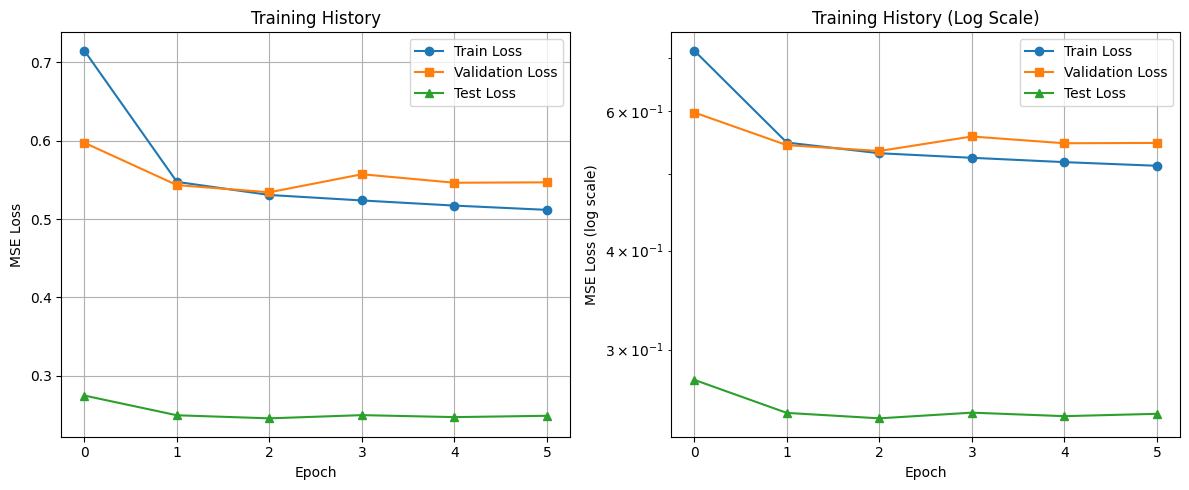

In [ ]:
# Plot training history with per-group breakdown
if os.path.exists(dataset_path) and len(train_losses) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Overall training curves
    axes[0, 0].plot(train_losses, label='Train Loss', marker='o', markersize=3)
    axes[0, 0].plot(val_losses, label='Validation Loss', marker='s', markersize=3)
    axes[0, 0].plot(test_losses, label='Test Loss', marker='^', markersize=3)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MSE Loss')
    axes[0, 0].set_title('Overall Training History')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Log scale
    axes[0, 1].plot(train_losses, label='Train Loss', marker='o', markersize=3)
    axes[0, 1].plot(val_losses, label='Validation Loss', marker='s', markersize=3)
    axes[0, 1].plot(test_losses, label='Test Loss', marker='^', markersize=3)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MSE Loss (log scale)')
    axes[0, 1].set_title('Training History (Log Scale)')
    axes[0, 1].set_yscale('log')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Per-group training losses
    colors = {'fast': 'red', 'medium': 'green', 'slow': 'blue'}
    for group_name, losses in group_train_losses.items():
        if len(losses) > 0:
            patch_len = args.patch_configs[group_name]['patch_len']
            axes[1, 0].plot(losses, label=f'{group_name} (patch={patch_len})', 
                           color=colors[group_name], marker='o', markersize=3)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('MSE Loss')
    axes[1, 0].set_title('Per-Group Training Losses (Different Patch Lengths)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Final per-group comparison (bar chart)
    if len(group_train_losses['fast']) > 0:
        group_names = list(group_train_losses.keys())
        final_losses = [group_train_losses[name][-1] for name in group_names]
        patch_lens = [args.patch_configs[name]['patch_len'] for name in group_names]
        
        bars = axes[1, 1].bar(group_names, final_losses, color=[colors[n] for n in group_names])
        axes[1, 1].set_xlabel('Channel Group')
        axes[1, 1].set_ylabel('Final Training MSE')
        axes[1, 1].set_title('Final Loss by Channel Group')
        
        # Add patch length annotations
        for bar, pl in zip(bars, patch_lens):
            axes[1, 1].annotate(f'patch={pl}', 
                               xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                               ha='center', va='bottom', fontsize=9)
        axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 6. Model Checkpointing <a id='checkpointing'></a>

Learn how to save and load model checkpoints.

In [43]:
# Save model checkpoint with additional information
def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'config': vars(args)
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to: {filepath}")

# Save current model
if os.path.exists(dataset_path):
    custom_checkpoint_path = os.path.join(checkpoint_path, 'model_final.pth')
    save_checkpoint(
        model, 
        optimizer, 
        args.train_epochs,
        train_losses[-1] if train_losses else 0,
        val_losses[-1] if val_losses else 0,
        custom_checkpoint_path
    )

Checkpoint saved to: /content/model/checkpoints_weather/PatchTST_custom_sl512_pl336_patch16/model_final.pth


In [44]:
# Load model checkpoint
def load_checkpoint(filepath, model, optimizer=None):
    checkpoint = torch.load(filepath, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint.get('epoch', 0)
    train_loss = checkpoint.get('train_loss', None)
    val_loss = checkpoint.get('val_loss', None)
    
    print(f"Checkpoint loaded from: {filepath}")
    print(f"  Epoch: {epoch}")
    if train_loss is not None:
        print(f"  Train Loss: {train_loss:.7f}")
    if val_loss is not None:
        print(f"  Val Loss: {val_loss:.7f}")
    
    return model, optimizer, epoch

# Example: Load the saved checkpoint
if os.path.exists(dataset_path):
    if os.path.exists(custom_checkpoint_path):
        model, optimizer, epoch = load_checkpoint(custom_checkpoint_path, model, optimizer)
    else:
        print("No checkpoint found to load.")

Checkpoint loaded from: /content/model/checkpoints_weather/PatchTST_custom_sl512_pl336_patch16/model_final.pth
  Epoch: 100
  Train Loss: 0.5117628
  Val Loss: 0.5468893


## 7. Evaluation and Visualization <a id='evaluation'></a>

Evaluate the model on the test set and visualize predictions.

In [ ]:
# Comprehensive evaluation with per-group analysis
def evaluate_variable_length_model(model, test_loader, device, args):
    model.eval()
    preds = []
    trues = []
    inputs = []
    
    with torch.no_grad():
        for batch_x, batch_y, batch_x_mark, batch_y_mark in test_loader:
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            
            # Forward pass
            outputs = model(batch_x)
            
            # Extract predictions
            f_dim = -1 if args.features == 'MS' else 0
            outputs = outputs[:, -args.pred_len:, f_dim:]
            batch_y = batch_y[:, -args.pred_len:, f_dim:]
            
            preds.append(outputs.detach().cpu().numpy())
            trues.append(batch_y.detach().cpu().numpy())
            inputs.append(batch_x.detach().cpu().numpy())
    
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    inputs = np.concatenate(inputs, axis=0)
    
    # Overall metrics
    mae, mse, rmse, mape, mspe, rse, corr = metric(preds, trues)
    
    print("\n" + "=" * 70)
    print("Variable-Length PatchTST - Test Set Evaluation")
    print("=" * 70)
    print(f"\nOVERALL METRICS:")
    print(f"  MSE:  {mse:.7f}")
    print(f"  MAE:  {mae:.7f}")
    print(f"  RMSE: {rmse:.7f}")
    print(f"  MAPE: {mape:.7f}")
    
    # Per-group metrics
    print(f"\nPER-GROUP METRICS:")
    group_metrics = {}
    for group_name, group_info in args.channel_groups.items():
        indices = group_info['indices']
        patch_len = args.patch_configs[group_name]['patch_len']
        
        group_preds = preds[:, :, indices]
        group_trues = trues[:, :, indices]
        
        g_mae, g_mse, g_rmse, g_mape, _, _, _ = metric(group_preds, group_trues)
        group_metrics[group_name] = {'mse': g_mse, 'mae': g_mae, 'rmse': g_rmse}
        
        print(f"\n  {group_name.upper()} (patch_len={patch_len}, {len(indices)} channels):")
        print(f"    MSE:  {g_mse:.7f}")
        print(f"    MAE:  {g_mae:.7f}")
        print(f"    RMSE: {g_rmse:.7f}")
    
    print("=" * 70)
    
    return preds, trues, inputs, {'overall': {'mse': mse, 'mae': mae}, 'groups': group_metrics}

# Run evaluation
if os.path.exists(dataset_path):
    preds, trues, inputs, metrics = evaluate_variable_length_model(model, test_loader, device, args)


Test Set Evaluation Metrics:
  MSE:  0.2457449
  MAE:  0.2824245
  RMSE: 0.4957266
  MAPE: 14.3135729
  MSPE: 22073318.0000000
  RSE:  0.6510147
  CORR: 0.4166142 (mean)


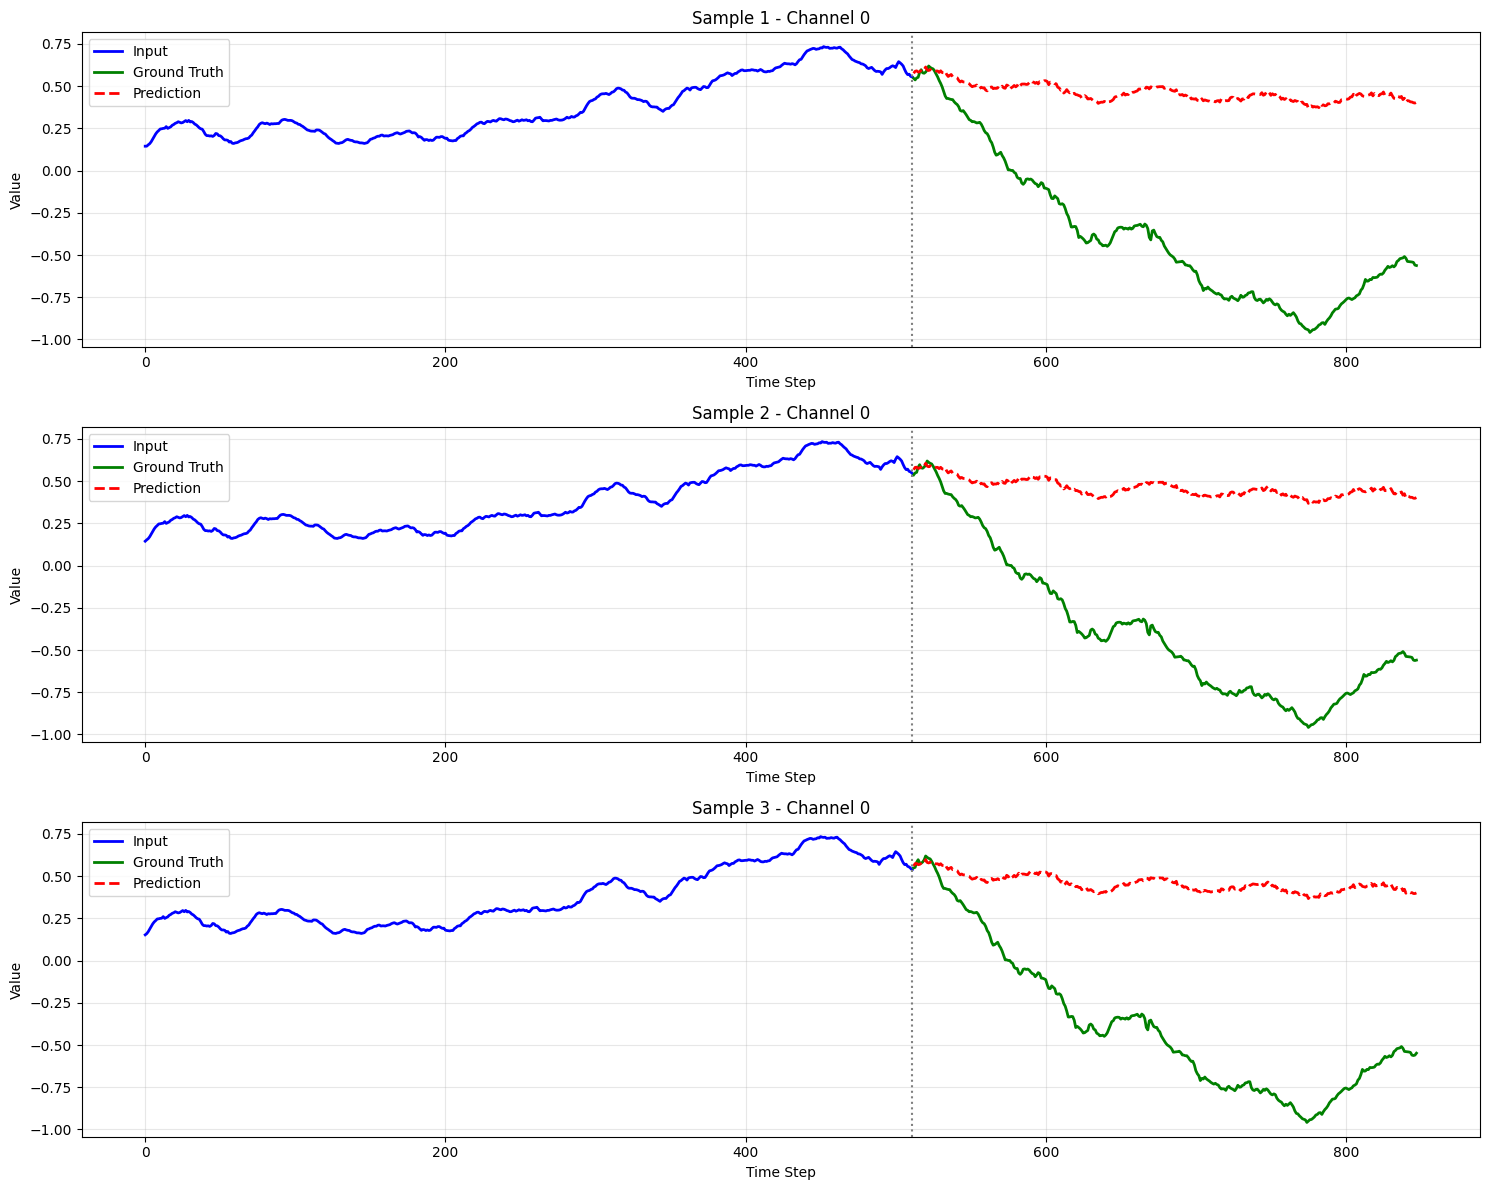

In [36]:
# Visualize predictions
def plot_predictions(inputs, trues, preds, num_samples=3, channel_idx=0):
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 4*num_samples))
    
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        # Concatenate input and prediction/ground truth
        input_seq = inputs[i, :, channel_idx]
        true_seq = trues[i, :, channel_idx]
        pred_seq = preds[i, :, channel_idx]
        
        # Time steps
        input_steps = np.arange(len(input_seq))
        pred_steps = np.arange(len(input_seq), len(input_seq) + len(pred_seq))
        
        # Plot
        axes[i].plot(input_steps, input_seq, 'b-', label='Input', linewidth=2)
        axes[i].plot(pred_steps, true_seq, 'g-', label='Ground Truth', linewidth=2)
        axes[i].plot(pred_steps, pred_seq, 'r--', label='Prediction', linewidth=2)
        axes[i].axvline(x=len(input_seq)-1, color='gray', linestyle=':', linewidth=1.5)
        axes[i].set_title(f'Sample {i+1} - Channel {channel_idx}')
        axes[i].set_xlabel('Time Step')
        axes[i].set_ylabel('Value')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot sample predictions
if os.path.exists(dataset_path):
    plot_predictions(inputs, trues, preds, num_samples=3, channel_idx=0)

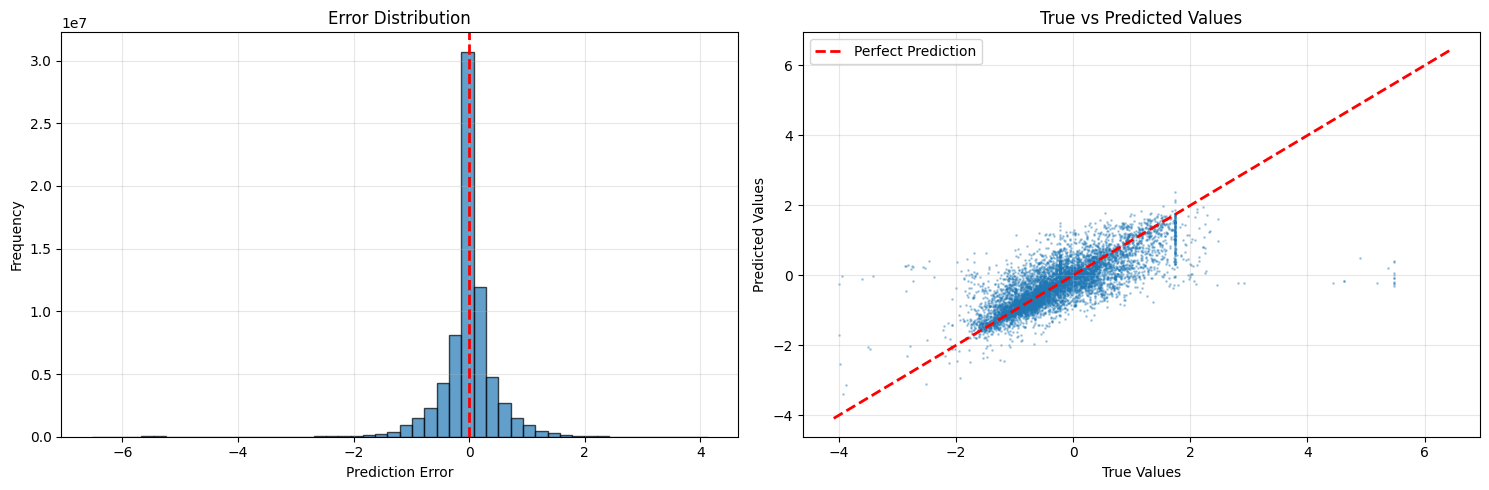

In [37]:
# Plot prediction error distribution
if os.path.exists(dataset_path):
    errors = preds - trues
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Error distribution
    axes[0].hist(errors.flatten(), bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Prediction Error')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Error Distribution')
    axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0].grid(True, alpha=0.3)
    
    # Scatter plot: True vs Predicted
    sample_size = min(10000, preds.size)
    indices = np.random.choice(preds.size, sample_size, replace=False)
    axes[1].scatter(trues.flatten()[indices], preds.flatten()[indices], alpha=0.3, s=1)
    
    # Add perfect prediction line
    min_val = min(trues.flatten().min(), preds.flatten().min())
    max_val = max(trues.flatten().max(), preds.flatten().max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    axes[1].set_xlabel('True Values')
    axes[1].set_ylabel('Predicted Values')
    axes[1].set_title('True vs Predicted Values')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Per-Channel Performance:
Channel    MSE             MAE             RMSE           
0          0.7925929       0.6366330       0.8902769      
1          0.1876575       0.3110310       0.4331945      
2          0.2014555       0.3149414       0.4488379      
3          0.2300079       0.3644374       0.4795914      
4          0.3373619       0.4589559       0.5808287      
5          0.0964392       0.2128024       0.3105465      
6          0.1920229       0.3197139       0.4382042      
7          0.0589059       0.1724666       0.2427053      
8          0.1925605       0.3188206       0.4388171      
9          0.1930403       0.3193647       0.4393635      
10         0.2902828       0.3734437       0.5387790      
11         0.0007490       0.0208559       0.0273685      
12         0.6010987       0.5867221       0.7753056      
13         0.4105800       0.4357634       0.6407652      
14         0.0516860       0.0538713       0.2273455      
15         1.0635488       0.3

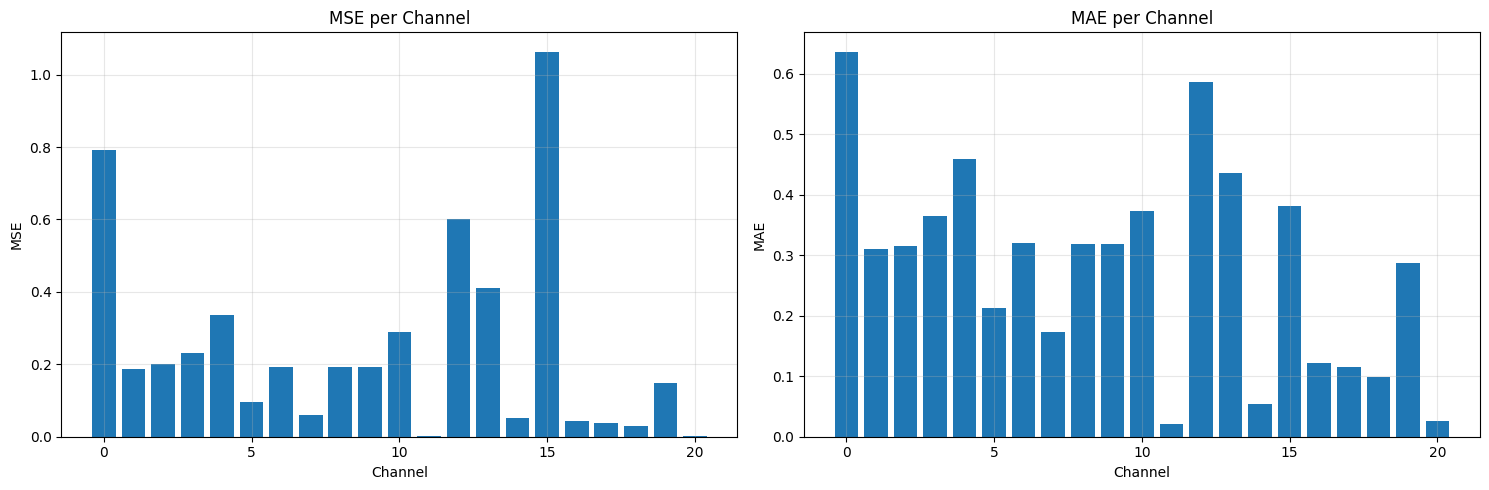

In [ ]:
# Per-channel and per-group performance analysis
if os.path.exists(dataset_path):
    # Calculate per-channel metrics
    num_channels = preds.shape[-1]
    channel_metrics = []
    
    print("\nPer-Channel Performance (grouped by patch length):")
    print("=" * 80)
    
    # Group channels by their encoder type
    for group_name, group_info in args.channel_groups.items():
        patch_len = args.patch_configs[group_name]['patch_len']
        print(f"\n{group_name.upper()} GROUP (patch_len={patch_len}):")
        print(f"{'Channel':<8} {'Name':<20} {'MSE':<12} {'MAE':<12} {'RMSE':<12}")
        print("-" * 70)
        
        for i, ch_idx in enumerate(group_info['indices']):
            ch_pred = preds[:, :, ch_idx]
            ch_true = trues[:, :, ch_idx]
            
            ch_mse = np.mean((ch_pred - ch_true) ** 2)
            ch_mae = np.mean(np.abs(ch_pred - ch_true))
            ch_rmse = np.sqrt(ch_mse)
            
            ch_name = group_info['names'][i] if i < len(group_info['names']) else f'Ch{ch_idx}'
            channel_metrics.append({
                'channel': ch_idx, 
                'name': ch_name,
                'group': group_name,
                'patch_len': patch_len,
                'mse': ch_mse, 
                'mae': ch_mae, 
                'rmse': ch_rmse
            })
            print(f"{ch_idx:<8} {ch_name:<20} {ch_mse:<12.7f} {ch_mae:<12.7f} {ch_rmse:<12.7f}")
    
    print("=" * 80)
    
    # Visualize grouped performance
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    colors = {'fast': 'red', 'medium': 'green', 'slow': 'blue'}
    
    # MSE by channel (colored by group)
    for m in channel_metrics:
        axes[0].bar(m['channel'], m['mse'], color=colors[m['group']], alpha=0.7)
    axes[0].set_xlabel('Channel Index')
    axes[0].set_ylabel('MSE')
    axes[0].set_title('MSE per Channel (colored by patch group)')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Create legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[g], label=f'{g} (patch={args.patch_configs[g]["patch_len"]})') 
                       for g in colors.keys()]
    axes[0].legend(handles=legend_elements, loc='upper right')
    
    # MAE by channel
    for m in channel_metrics:
        axes[1].bar(m['channel'], m['mae'], color=colors[m['group']], alpha=0.7)
    axes[1].set_xlabel('Channel Index')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('MAE per Channel (colored by patch group)')
    axes[1].legend(handles=legend_elements, loc='upper right')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Group-level comparison
    group_names = list(args.channel_groups.keys())
    group_mses = [metrics['groups'][g]['mse'] for g in group_names]
    group_patch_lens = [args.patch_configs[g]['patch_len'] for g in group_names]
    
    bars = axes[2].bar(group_names, group_mses, color=[colors[g] for g in group_names])
    axes[2].set_xlabel('Channel Group')
    axes[2].set_ylabel('Group MSE')
    axes[2].set_title('Average MSE by Channel Group')
    for bar, pl in zip(bars, group_patch_lens):
        axes[2].annotate(f'patch={pl}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                        ha='center', va='bottom', fontsize=10)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 8. Advanced: Custom Channel Groupings <a id='advanced'></a>

Experiment with different channel groupings and patch lengths based on domain knowledge.

In [ ]:
# Analyze optimal patch lengths for each channel group
print("Patch Length Analysis for Weather Variables")
print("=" * 70)

# Show reasoning for each group
reasoning = {
    'fast': """
    FAST-CHANGING VARIABLES (Wind, Precipitation):
    - Wind speed/direction can change within minutes
    - Precipitation events are episodic (start/stop quickly)
    - Need short patches (12 steps = 2 hours) to capture rapid fluctuations
    - Longer patches would smooth out important variations
    """,
    'medium': """
    MEDIUM-CHANGING VARIABLES (Humidity, Vapor Pressure):
    - Change over hours, not minutes
    - Follow weather fronts and air mass movements
    - Medium patches (24 steps = 4 hours) capture typical event duration
    - Balance between detail and context
    """,
    'slow': """
    SLOW-CHANGING VARIABLES (Temperature, Pressure Trends):
    - Follow diurnal (daily) cycles
    - Synoptic-scale patterns (days)
    - Long patches (48 steps = 8 hours) capture trends
    - Short patches would miss the bigger picture
    """
}

for group_name, text in reasoning.items():
    print(f"\n{group_name.upper()}:")
    print(text)

# Calculate effective receptive fields
print("\n" + "=" * 70)
print("Effective Receptive Fields:")
print("=" * 70)
for group_name, cfg in args.patch_configs.items():
    patch_len = cfg['patch_len']
    stride = cfg['stride']
    n_patches = int((args.seq_len - patch_len) / stride + 1) + 1  # +1 for padding
    receptive_field = n_patches * stride + (patch_len - stride)
    
    print(f"\n{group_name}:")
    print(f"  Patch length: {patch_len} steps ({patch_len * 10} min)")
    print(f"  Stride: {stride} steps ({stride * 10} min)")
    print(f"  Number of patches: {n_patches}")
    print(f"  Effective receptive field: {receptive_field} steps ({receptive_field * 10 / 60:.1f} hours)")
print("=" * 70)

Patch Length Impact Analysis

Patch Length: 8, Stride: 4
  Number of patches: 128
  Input tokens to Transformer: 128
  Receptive field coverage: 516

Patch Length: 16, Stride: 8
  Number of patches: 64
  Input tokens to Transformer: 64
  Receptive field coverage: 520

Patch Length: 32, Stride: 16
  Number of patches: 32
  Input tokens to Transformer: 32
  Receptive field coverage: 528


In [ ]:
# Create alternative channel groupings for experimentation

# Alternative 1: More granular grouping (5 groups)
WEATHER_CHANNELS_V2 = {
    'very_fast': {
        'indices': [7, 8],  # Wind speed only
        'names': ['wv (m/s)', 'max. wv (m/s)'],
        'patch_len': 8,
        'stride': 4,
    },
    'fast': {
        'indices': [9, 10, 11],  # Wind direction, precipitation
        'names': ['wd (deg)', 'rain (mm)', 'raining (s)'],
        'patch_len': 16,
        'stride': 8,
    },
    'medium': {
        'indices': [3, 4, 5, 6],  # Humidity-related
        'names': ['rh (%)', 'VPmax', 'VPact', 'VPdef'],
        'patch_len': 24,
        'stride': 12,
    },
    'slow': {
        'indices': [0, 12, 13, 14],  # Pressure, concentration
        'names': ['p (mbar)', 'sh', 'H2OC', 'rho'],
        'patch_len': 36,
        'stride': 18,
    },
    'very_slow': {
        'indices': [1, 2, 15, 16, 17, 18, 19, 20],  # Temperature-related
        'names': ['T (degC)', 'Tpot', 'Tdew', 'Tlog', 'CO2', 'PAR', 'Tmax', 'Tmin'],
        'patch_len': 48,
        'stride': 24,
    }
}

print("Alternative Channel Grouping (5 groups - more granular):")
print("=" * 70)
for group_name, group_info in WEATHER_CHANNELS_V2.items():
    print(f"\n{group_name}:")
    print(f"  Channels: {group_info['indices']}")
    print(f"  Patch: {group_info['patch_len']} steps, Stride: {group_info['stride']} steps")

# Alternative 2: Physics-based grouping
WEATHER_CHANNELS_PHYSICS = {
    'atmospheric_dynamics': {
        'indices': [0, 7, 8, 9],  # Pressure, wind
        'names': ['p (mbar)', 'wv', 'max wv', 'wd'],
        'patch_len': 24,  # Synoptic scale
        'stride': 12,
    },
    'thermodynamics': {
        'indices': [1, 2, 15, 16, 18, 19, 20],  # All temperature
        'names': ['T', 'Tpot', 'Tdew', 'Tlog', 'Tmax', 'Tmin', 'CO2'],
        'patch_len': 48,  # Diurnal cycle
        'stride': 24,
    },
    'moisture': {
        'indices': [3, 4, 5, 6, 12, 13, 14],  # Humidity, vapor
        'names': ['rh', 'VPmax', 'VPact', 'VPdef', 'sh', 'H2OC', 'rho'],
        'patch_len': 32,  # Moisture transport
        'stride': 16,
    },
    'precipitation': {
        'indices': [10, 11, 17],  # Rain, radiation
        'names': ['rain', 'raining', 'PAR'],
        'patch_len': 12,  # Convective events
        'stride': 6,
    }
}

print("\n\nPhysics-Based Channel Grouping:")
print("=" * 70)
for group_name, group_info in WEATHER_CHANNELS_PHYSICS.items():
    print(f"\n{group_name}:")
    print(f"  Channels: {group_info['indices']}")
    print(f"  Physical reasoning: Related variables grouped together")
    print(f"  Patch: {group_info['patch_len']} steps ({group_info['patch_len']*10/60:.1f} hours)")
print("=" * 70)


Model Variants Comparison:

PatchTST-Small:
  Parameters: 1,448,722
  Config: {'d_model': 64, 'n_heads': 4, 'e_layers': 2, 'd_ff': 128}

PatchTST-Large:
  Parameters: 7,634,516
  Config: {'d_model': 256, 'n_heads': 16, 'e_layers': 4, 'd_ff': 512}

PatchTST-Decomposition:
  Parameters: 6,321,318
  Config: {'decomposition': 1, 'kernel_size': 25}

PatchTST-Decomposition:
  Parameters: 6,321,318
  Config: {'decomposition': 1, 'kernel_size': 25}


In [ ]:
# Benchmark: Variable-Length vs Fixed-Length comparison
print("\nModel Comparison: Variable-Length vs Fixed-Length PatchTST")
print("=" * 70)

# Variable-length model (already created)
vl_total, vl_trainable = count_parameters(model)

# Create fixed-length baseline for comparison
class FixedLengthBaseline(nn.Module):
    """Fixed patch length baseline (original PatchTST style)"""
    def __init__(self, configs, patch_len=16, stride=8):
        super().__init__()
        self.enc_in = configs.enc_in
        self.pred_len = configs.pred_len
        
        self.encoder = PerChannelEncoder(
            n_channels=configs.enc_in,
            context_window=configs.seq_len,
            target_window=configs.pred_len,
            patch_len=patch_len,
            stride=stride,
            n_layers=configs.e_layers,
            d_model=configs.d_model,
            n_heads=configs.n_heads,
            d_ff=configs.d_ff,
            dropout=configs.dropout,
            head_dropout=configs.head_dropout
        )
        
        self.revin = configs.revin
        if self.revin:
            self.revin_layer = RevIN(configs.enc_in, affine=configs.affine, 
                                      subtract_last=configs.subtract_last)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # [bs, enc_in, seq_len]
        
        if self.revin:
            x = x.permute(0, 2, 1)
            x = self.revin_layer(x, 'norm')
            x = x.permute(0, 2, 1)
        
        output = self.encoder(x)  # [bs, enc_in, pred_len]
        output = output.permute(0, 2, 1)  # [bs, pred_len, enc_in]
        
        if self.revin:
            output = self.revin_layer(output, 'denorm')
        
        return output

# Create baseline model
baseline_model = FixedLengthBaseline(args, patch_len=16, stride=8).float().to(device)
bl_total, bl_trainable = count_parameters(baseline_model)

# Compare
print(f"\n{'Model':<30} {'Parameters':>15} {'Size (MB)':>12}")
print("-" * 60)
print(f"{'Fixed-Length (patch=16)':<30} {bl_total:>15,} {bl_total * 4 / 1024 / 1024:>12.2f}")
print(f"{'Variable-Length (12/24/48)':<30} {vl_total:>15,} {vl_total * 4 / 1024 / 1024:>12.2f}")
print(f"{'Difference':<30} {vl_total - bl_total:>+15,} {(vl_total - bl_total) * 4 / 1024 / 1024:>+12.2f}")

# Inference speed comparison
input_shape = (args.batch_size, args.seq_len, args.enc_in)

print(f"\nInference Speed (batch_size={args.batch_size}):")
print("-" * 60)

for name, m in [("Fixed-Length", baseline_model), ("Variable-Length", model)]:
    avg_time = benchmark_model(m, input_shape, num_runs=50)
    print(f"{name:<30}: {avg_time:.2f} ms/batch")

print("=" * 70)


Inference Speed Comparison (ms per batch):
Original Model      : 39.86 ms
Small Model         : 8.09 ms
Large Model         : 86.14 ms


## Summary: Variable-Length PatchTST

This notebook implemented **Variable-Length PatchTST** with per-channel-group patch lengths while maintaining channel-independent processing.

### Key Features:

1. **Per-Channel-Type Patch Lengths**:
   - **Fast-changing variables** (wind, precipitation): 12-step patches (2 hours)
   - **Medium-changing variables** (humidity, pressure): 24-step patches (4 hours)
   - **Slow-changing variables** (temperature): 48-step patches (8 hours)

2. **Channel-Independent Processing**:
   - Each channel is still processed independently (no cross-channel attention)
   - Each channel group uses its own encoder with optimized patch length
   - Maintains efficiency while adapting to variable dynamics

3. **Why This Works for Weather Data**:
   - Weather variables have different temporal dynamics
   - Wind changes rapidly → needs fine-grained patches
   - Temperature changes slowly → needs coarse patches to capture trends
   - Pressure/humidity are intermediate → medium patch length

### Architecture Comparison:

| Aspect | Original PatchTST | Variable-Length PatchTST |
|--------|------------------|-------------------------|
| Patch Length | Fixed (16) | Variable (12/24/48 per group) |
| Channel Processing | Independent | Independent (grouped) |
| Temporal Adaptation | None | Per-variable-type |
| Parameters | Single encoder | 3 specialized encoders |
| Memory | Lower | ~1.5x (3 encoders) |

### Next Steps:
- Compare with original fixed-patch PatchTST
- Tune patch lengths per channel (not just per group)
- Add learnable patch length selection
- Combine with cross-channel attention for specific variable pairs

### References:
- PatchTST Paper: https://arxiv.org/abs/2211.14730
- This enhancement: Per-channel-group variable-length patching